In [111]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
import pandas as pd
import glob
import matplotlib.pyplot as plt
import specmatchemp.library
import specmatchemp.plots as smplot
from scipy.integrate import trapz
from scipy.constants import pi, h, c, k
from pandas.api.types import CategoricalDtype
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import CustomJS, Button
from bokeh.layouts import row, column

h*=1e7 # Planck constant in erg*s
c*=1e2 # light speed in cm/s
k*=1e7 # Boltzmann constant in erg/K

def dprint(str,debug):
    
    '''
    Prints out all help text snippets where the debug flag is passed.
    '''
    
    if debug==True:
        print(str)
    return

def display(opt,d,debug):
    
    '''
    Displays additional information about a resulting 
    combo _opt_ of spectral classes given some colors 
    and approximates their likelihood by the mutual distance
    between the rows _d_. Conditional on the _debug_ flag being passed.
    '''
    
    dprint('New combination: {}'.format(opt),debug)
    dprint('This combination has distance {}'.format(d),debug)
    
    return

def spec_class_hist(specs,cluster,sort):

    counts = specs.spec_class.value_counts(sort=False)
    y = counts.sort_index()
    plot = y.plot(kind = 'bar',color='blue')
    fig = plot.get_figure()
    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/clean_CMD_{}.jpg'.format(cluster),dpi=300)
    return

def CMD(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5),outliers=pd.Series()):
    '''
    Plots and saves CMDs for specified bands, 
    marks outliers if any are passed.
    '''
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,kind = 'scatter', 
                      color=color_outlier_red(specs.index.values,outliers))
    plot.set_ylabel(cid1[0])
    plot.set_xlabel('{}-{}'.format(cid1[0],cid2[0]))
    fig = plot.get_figure()
    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/CMD_{}_{}.jpg'.format(cluster,color),dpi=300)
    return



def color_outlier_red(val,outliers):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if outliers.empty: outliers=[]
    color=[]
    for id_ in val:
        if id_ in list(outliers):
            color.append('red')
        else:
            color.append('black')
    #color = ['red' if val in outliers else 'black'
    return color


def interactive_CMD(specs,cid1='gmag',cid2='imag'):
    '''
    Simplistic tool to create an interactive 
    bokeh plot where outliers can be marked and saved in
    '/home/ekaterina/Documents/appaloosa/stars_shortlist/share/temp'
    '''
    # Create some random data and put it into a ColumnDataSource
    x = list(specs[cid1]-specs[cid2])
    y = list(specs[cid2])
    z = list(specs.index.values)
    source_data = ColumnDataSource(data=dict(x=x, y=y,desc=z))
    
    # Create a button that saves the coordinates of selected data points to a file
    savebutton = Button(label="Save", button_type="success")
    savebutton.callback = CustomJS(args=dict(source_data=source_data), code="""
            var inds = source_data.selected['1d'].indices;
            var data = source_data.data;
            var out = "";
            for (i = 0; i < inds.length; i++) {
                out += data['desc'][inds[i]] + " ";
            }
            var file = new Blob([out], {type: 'text/plain'});
            var elem = window.document.createElement('a');
            elem.href = window.URL.createObjectURL(file);
            elem.download = 'selected-data.txt';
            document.body.appendChild(elem);
            elem.click();
            document.body.removeChild(elem);
            """)

    # Plot the data and save the html file
    p = figure(plot_width=800, plot_height=400, 
               y_range=(16,7),
               tools="lasso_select, reset",)
    p.circle(x='x', y='y', source=source_data)
    p.xaxis.axis_label = '{}-{}'.format(cid1[0],cid2[0])
    p.yaxis.axis_label = cid1[0]
    plot = column(p, savebutton)
    output_file("test.html")
    show(plot)
    return

#----------------------------------------
#ENERGY CALC
#---------------------------------------

#Solution to nan-bug:
#https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return

#End: Solution to nan_bug

def spectrum(T, lib, wavmin=3480., wavmax=9700.):
    
    '''
    
    Returns the spectrum of a star at effective temperature T in wavelength range [wavmin,wavmax]
    Default range corresponds to Kepler response
    
    '''
    #loads library of spectra within wavelength range
    
    if T > 7000:
        print('{}K is hotter than 7000K.'.format(T))
        return lib.wav, []
    elif T < 3000:
        print('{}K is cooler than 3000K.'.format(T))
        return lib.wav, []
    else: 

        #find the spectrum that fits T best
        print('T=',T)
        Tmin = str(T-100.)
        Tmax = str(T+100.)
        cut = lib.library_params.query(Tmin+'<Teff<'+Tmax)
        #print('cut\n',cut.head())
        T_offer = zip(list(cut['Teff']), list(cut['lib_index']))
        T_minindex = min(T_offer, key = lambda t: abs(t[0]-T))[1]
        cut = cut.loc[T_minindex]
        #return the spectrum
        spec = lib.library_spectra[cut.lib_index,0,:]
        return lib.wav, spec.T

def kepler_spectrum(T,lib,deriv=False):
    '''
    
    Convolves a blackbody of effective temperature T, 
    the spectrum of a dwarf star with corresponding spectral class,
    and the Kepler response function 
    to return the wavelength dependent flux of that star per area
    
    Parameters:
    -----------
    T - effective temperatur in K
    
    Returns:
    --------
    Kp_flux in erg/cm*(cm**2)
    Kp_midwav in angström
    
    
    '''
    Kp = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/Kepler_response.txt',
                                  skiprows=9,
                                  header=None,
                                  delimiter='\t',
                                  names=['wav','resp'])
    Kp.wav = Kp.wav.astype(np.float)*10. #convert to angström for spectrum function
    #load the spectrum within a wavelength range that fits given T_eff best
    Spec_wav, Spec_flux = spectrum(T,lib,Kp.wav.min(),Kp.wav.max())
    #map Kepler response linearly into wavelengths given with the spectrum
    if Spec_flux == []:
        print('{}K is too hot or too cool for specmatch-emp.'.format(T))
        return [],[],[]
    else:
        Spec_flux = np.interp(Kp.wav,Spec_wav,Spec_flux)
        Kp_flux = np.empty(Kp.wav.shape[0]-1)
        Kp_midwav  = np.empty(Kp.wav.shape[0]-1)
        planck  = np.empty(Kp.wav.shape[0]-1)
        #calculate the flux of a star with given T_eff 
        #accounting for Kepler filter 
        #and the corresp. spectrum of that stellar type 
        try:
            for i, response in Kp.resp[:-1].iteritems():
                dlambda = (Kp.wav[i+1]-Kp.wav[i])*1e-8 #infin. element of wavelength in cm
                lambda_ = Kp.wav[i:i+2].mean()*1e-8 #wavelength in cm
                Kp_midwav[i] = lambda_
                if deriv == False:
                    planck[i] = 2. * h * c**2 / lambda_**5 / (np.exp( h * c / ( lambda_ * k * T ) ) - 1. )     
                elif deriv == True:
                    e_ = np.exp( h * c / ( lambda_ * k * T ) )
                    planck[i] = 2. * h**2 * c**3 / lambda_**6 / T**2 / k / (e_ - 1. )**2 * e_     
                Kp_flux[i] = Spec_flux[i] * response * planck[i]
        except IndexError:
            pass
        
        return Kp_midwav, Kp_flux, planck

def plot_kepler_spectrum(T):

    wav, flux, planck = kepler_spectrum(T,lib)
    
    Kp = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/Kepler_response.txt',
                                  skiprows=9,
                                  header=None,
                                  delimiter='\t',
                                  names=['wav','resp'])

    if flux == []:
        return print('No data for T = {}K'.format(T))
    else:
        plt.figure()
        plt.plot(wav*1e8, flux,color='green')
        plt.plot(wav*1e8, Kp.resp[:-1]*planck.max(),color='red')
        plt.plot(wav*1e8, planck,color='black')
        plt.show()  
    return

def kepler_luminosity(T,lib, error=False):
    
    '''
    Integrates the Kepler flux,
    multiplies by the area A=pi*(R**2),
    to obtain observed quiescent flux for an object
    
    Return:
    
    total Kepler luminosity in erg/s of a dwarf star with effective temperature T
    
    '''
    
    params=pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/merged_specs.csv')
    
    #calculate Kepler spectrum of a dwarf star with temperature T
    print(T)
    if error==False:
        wav, flux, _ = kepler_spectrum(T,lib)
    elif error==True:
        wav, flux, _ = kepler_spectrum(T,lib,deriv=True)
        
    if flux == []:
        return print('{}K is too hot or too cold'.format(T))
    else:
        #interpolate where nans occur
        interpolate_nan(wav)
        interpolate_nan(flux)

        #select the relevant columns from params
        radii_teff = params[['T','R_Rsun']]
        radii_teff.set_index('T',inplace=True)
        radius_cm = radii_teff.R_Rsun[T]*6.96342e10 #stellar radius in cm
        if error == False:
            return np.trapz(flux, wav) * pi * (radius_cm**2)
        elif error == True:
            return np.trapz(flux, wav) * pi * (radius_cm**2)
    
def Kp_to_Lum(df, dm, Kp='Kp'):
    df['Kp_abs'] = df[Kp]+dm
    #print(df.head())
    return

def Mbol_to_Lum(Mbol):
    
    '''
    Returns:
    --------
    Bolometric luminosity of a star with Mbol in erg/s.
    '''
    
    Lum_Sun = 3.84e33 #erg/s
    Mbol_Sun = 4.74 #mag
    return Lum_Sun * 10**( Mbol_Sun - Mbol )

#-------------------------------
#FFD
#-------------------------------

def ED(start,stop,time,flux_model,flux_gap, error):
    
    '''
    Returns the equivalend duratio of a flare event,
    found within indices [start, stop],
    calculated as the area under the residual (flux_gap-flux_model)
    Returns also the error on ED following (Davenport 2016)
    
    Parameters:
    --------------
    start - start time index of a flare event
    stop - end time index of a flare event
    time - time array
    flux_model - model quiescent flux 
    flux_gap - long-term trend removed raw light curve
    error - rolling std error to raw flux
    
    Returns:
    --------------
    ed - equivalent duration in seconds
    ederr - uncertainty in seconds
    '''
    
    start, stop = int(start),int(stop)
    time = np.asarray(time)[start:stop+1]
    model = np.asarray(flux_model)[start:stop+1]
    flux = np.asarray(flux_gap)[start:stop+1]
    error = np.asarray(error)[start:stop+1]
    residual = flux - model
    ed = trapz(residual/model,time*60.*60.*24.)
    #measure error on ED
    
    flare_chisq = chisq(flux, error, model)
    ederr = np.sqrt(ed**2 / (stop-start) / flare_chisq)
    return ed, ederr, flare_chisq

def chisq(data, error, model):
    '''
    Compute the normalized chi square statistic:
    chisq =  1 / N * SUM(i) ( (data(i) - model(i))/error(i) )^2
    '''
    return np.sum( ((data - model) / error)**2.0 ) / np.size(data)


def import_flares(cluster, test, oid):
    
    objectid = str(oid)
    loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
#    myloc = loc + '_my_flares.txt'
#     try:
#         myflares = pd.read_csv(myloc, names= ['start','stop','istart','istop','comment'])
#     except OSError:
#         myflares = []

    appaflares = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    appaids = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])
    return appaflares, appaids

def write_flares(forf,cluster, test, EPIC, typ='flares'):
    
    '''
    Writes a data frame with flares or flux 
    for a certain light curve with EPIC ID from a cluster
    analysed during a certain test.
    
    Parameter:
    ------------
    
    Returns:
    ------------
    '''
    
    loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
    if typ == 'flares':
        forf.to_csv('{}/{}_flares.csv'.format(loc,EPIC))
    elif typ == 'flux':
        forf.to_csv('{}/{}_flux.csv'.format(loc,EPIC))
    return 



def cum_hist(flares, flux, L_quiet,bins=5):
    ED_=[]
    s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']]
    s_s = s_s.dropna()
    for i,row in s_s.iterrows():
        #print(row['istart'])
        #ed = ED(row['istart'],row['istop'],flux.time,flux.flux_model,flux.flux_gap)
        ed, ederr = ED(row['istart_no_sys_no_thruster'],
                       row['istop_no_sys_no_thruster'],
                       flux.time,flux.flux_model,flux.flux_gap)
        
        if (ed != 'nan') & (ed >0):
            ED_.append(np.log10(ed*24.*60.*60.*L_quiet))
    
    #print(ED_)
    #ED_ = np.asarray(ED_)
    #ED_ = ED_.dropna()
    hist, edges=np.histogram(ED_, bins=bins)

    hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

    return hist, edges

def merged_spec_class(params):
    p = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/merged_specs.csv')
    colors = {'g_r':('gmag','rmag'),
              'r_i':('rmag','imag'),
              'i_z':('imag','zmag'),
              'z_J':('zmag','J'),
              'J_H':('J','H'),
              'H_K':('H','K'),
              'i-z':('imag','zmag'),
              'z-Y':('zmag','ymag'),
              'J-H':('J','H'),
              'H-K':('H','K'),}
    p['T_err'] = Terr(p['T'])
    p['R_Rsun_err'] =0.5*p.R_Rsun
    for col in p.columns.values:
        params[col]=np.nan
    for i, s in params.iterrows():
        _ = np.array([((s[item[0]]-s[item[1]])-p[key]).abs().argmin() for key, item in colors.items()])
        idx = np.int(np.median(_[~np.isnan(_)]))    
        for col in p.columns.values:
            params[col][i]=p[col].iloc[idx]

    params = params.join(p.iloc[idx])    
    return params

DM = lambda x: 5.*np.log10(float(x))-5. 

def L_quieterr(L, R, Rerr, T, Terr,lib):
    R*=6.96342e10 #stellar radius in cm
    Rerr*=6.96342e10 #stellar radius error in cm
    t1 = np.abs(L/R)
    deriv_L = kepler_luminosity(T, lib, error=True)
    t2 = np.abs(deriv_L)
    return t1 * Rerr + t2 * Terr

def Terr(Tseq):
    Terr = Tseq.rolling(window=3,center=True).std()
    Terr = Terr.fillna(100)
    print(Terr)
    return Terr

## Load parameters and calculate quiescent luminosity, assign spectral class and  if not already

In [118]:
cluster_dict = {'M67':['M67','M67', 15, 4.0, 850],
                'Ruprecht_147':['Ruprecht 147','Ruprecht_147', 30, 2.5, 300.],
                'M44':['M44','M44', 47, 0.73, 181.5],
                'M45':['M45','M45',55.,0.12,120.],
                'NGC_1647':['NGC 1647','NGC_1647',0.,0.145,550.],
                'Pleiades':['Pleiades','Pleiades',0.,0.100,136.]
               }

cluster = 'NGC_1647'
basics = cluster_dict[cluster]
test = 'run_01'
dm = DM(basics[4])
global dm
l = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/{0}_parameter.csv'.format(cluster)

print(glob.glob(l))
if glob.glob(l) != []:
    specs = pd.read_csv(l, index_col='EPIC')
else:
    print('Go back to step 6.')
    
specs[['T','T_err','L_quiet','L_quiet_err']].sort_values(by='T').head()

['/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647/NGC_1647_parameter.csv']


,T,T_err,L_quiet,L_quiet_err
EPIC,,,,
247166643,3410.0,126.622799,6.484489e+29,1.997846e+29
247131381,3500.0,70.945989,8.912156e+29,2.103680e+29
247159731,3500.0,70.945989,8.912156e+29,2.103680e+29
247135437,3700.0,76.376262,1.967146e+30,4.608452e+29
247158149,3800.0,85.440037,2.744186e+30,6.550460e+29


In [119]:
flarelist = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647/results/run_01/NGC_1647_run_01_flarelist.txt',
    delimiter='\t')
flarelist = flarelist[['Object ID ',' Number of Flares ']]
flarelist = flarelist.rename(index=str, columns= {'Object ID ':'EPIC',' Number of Flares ':'counts'})
flarelist = flarelist.set_index('EPIC')
specs = specs.join(flarelist, how='left')
print(specs.T_err.describe())


count     82.000000
mean     135.403075
std       57.357367
min       30.550505
25%       86.216781
50%      122.586069
75%      195.192213
max      210.000000
Name: T_err, dtype: float64


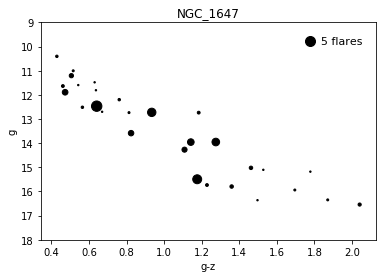

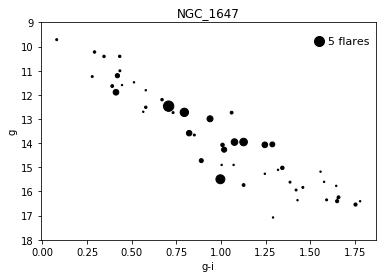

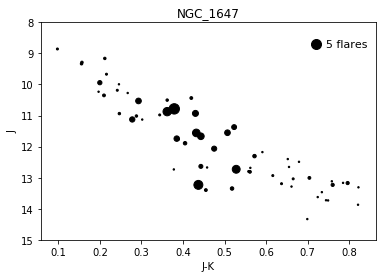

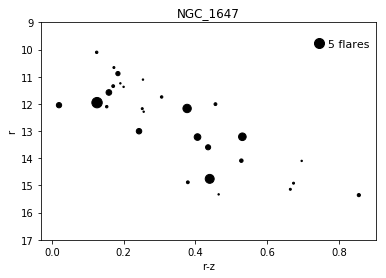

In [109]:
def CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5),outliers=pd.Series()):
    '''
    Plots and saves CMDs for specified bands, 
    marks outliers if any are passed.
    '''
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,
                      kind = 'scatter', 
                      color=color_outlier_red(specs.index.values,outliers),
                      s=list(specs['counts']*2.),
                      title = '{}'.format(cluster))
    plot.set_ylabel(cid1[0])
    plot.set_xlabel('{}-{}'.format(cid1[0],cid2[0]))
    plot.text(0.9*specs[color].max(), 1.1*ylim[1], r'5 flares', fontsize=11)
    plot.plot(0.87*specs[color].max(), 1.086*ylim[1], 'o', markersize=10,color='black')
    fig = plot.get_figure()
    plot
    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/CMD_{}_{}_counts.jpg'.format(cluster,color),dpi=300)
    return

CMD_count(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(18,9))
CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(18,9))
CMD_count(specs,cluster,cid1='J',cid2='K',color='J_K',ylim=(15,8))
CMD_count(specs,cluster,cid1='rmag',cid2='zmag',color='r_z',ylim=(17,9))

[-0.8093904  28.52983065] [0.2305455] 2 [1.41417493 0.01045362] 2.2426505097428162e-14
[-1.40207715 46.62098961] [0.00545008] 2 [1.41420945 0.00340856] 8.881784197001252e-16
[-1.22585996 41.59654343] [0.03462089] 2 [1.41419936 0.00633689] 6.8833827526759706e-15


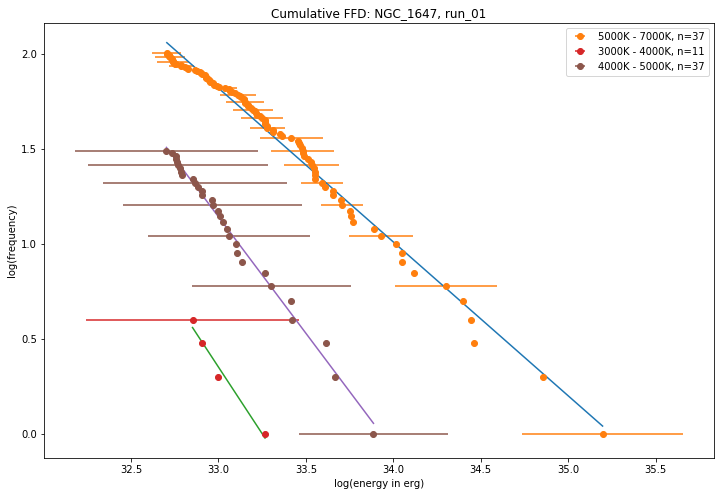

In [137]:
import fnmatch

def energy(oid_list, cluster, test, specs):
    clusterenergy, clusterenergy_err, clustered, clusterederr = [], [], [], []
    for oid in oid_list:
        flux, flares = import_flares(cluster, test, oid)
        L_quiet = specs['L_quiet'].loc[oid]
        L_quiet_err = specs['L_quiet_err'].loc[oid]
        s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']].dropna()
        tmyed, tenergy, tenergy_err = [],[],[]
        for i,row in s_s.iterrows():
            ed, ederr, chi2 = ED(row['istart_no_sys_no_thruster'],
                           row['istop_no_sys_no_thruster'],
                           flux.time,flux.flux_model,flux.flux_gap, flux.error)
            energy_err = energyerr(ed, ederr, L_quiet, L_quiet_err)
            if (ed != 'nan') & (ed > 0):
                clusterenergy.append(ed*L_quiet)
                clusterenergy_err.append(energy_err)
                tenergy.append(ed*L_quiet)
                tenergy_err.append(energy_err)
                tmyed.append(ed)
                clustered.append(ed)
                clusterederr.append(ederr)
            else:
                clusterenergy.append(np.nan)
                clusterenergy_err.append(np.nan)
                tenergy.append(np.nan)
                tenergy_err.append(np.nan)
                tmyed.append(np.nan)
                clustered.append(np.nan)
                clusterederr.append(np.nan)
        flares['myed'] = tmyed
        flares['myenerg'] = tenergy
        flares['myenerg_err'] = tenergy_err
        filtered = fnmatch.filter(flares.columns.values, 'Unnamed:*')
        flares = flares.drop(filtered,axis=1)
        c = pd.DataFrame({'clusterenergy':clusterenergy,
                                        'clusterenergy_err':clusterenergy_err,
                                        'clustered':clustered,
                                        'clusterederr':clusterederr})
        c['rel_energ_err']=c.clusterenergy_err/c.clusterenergy
        write_flares(flares, cluster, test, oid, typ='flares')
        c.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}/clusterenergies.csv'.format(cluster,test))
    return c

def energyerr(ed, ederr, L_quiet, L_quiet_err):
    #np.sqrt((ed * L_quiet_err)**2 + (ederr * L_quiet)**2) 
    return (ed * L_quiet_err) + (ederr * L_quiet)

def FFD(oid, cluster, test, specs,color='red'):
    flux, flares = import_flares(cluster, test, oid)
    T = specs['T'].loc[oid]
    L_quiet = specs['L_quiet'].loc[oid]
    histAppa, edgesAppa = cum_hist(flares, flux, L_quiet,bins=5)
    binmids=[(x+edgesAppa[i])/2. for i,x in enumerate(edgesAppa[1:])]
    return plt.plot(binmids[1:],np.log10(histAppa[1:]),color=color,alpha=0.8,label='EPIC {}, T={}K'.format(oid,T))

def cum_hist_average(oid_list, cluster, test, specs):

    c = energy(oid_list, cluster, test, specs)
    c = c.dropna(how='any')
    c = c.sort_values(by='clusterenergy')
    #hist, edges=np.histogram(np.log10(c.clusterenergy), bins=bins)
    c2 = np.asarray(c.clusterenergy_err**2)
    #binmids=[(x+edges[i])/2. for i,x in enumerate(edges[1:])]
    hist = np.ones_like(c.clusterenergy)
    hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)
    err = np.sqrt(np.flip(np.cumsum(np.flip(c2,axis=0)),axis=0))/hist
    df = pd.DataFrame({'hi':hist,
                       'energ':c.clusterenergy,
                       'err':err,})
    return df

def FFD_average(specs, cluster, test, class_='K7', 
                Tmin=3000., Tmax=7000., color='red',
                subset='class'):
    if subset == 'class':
        select = np.asarray([i for sublist in [specs[specs.spec_class.str.contains(c)].index.values 
                                               for c in class_] 
                                                 for i in sublist])
        label = '{}, n={}'.format(tuple(class_),len(select))
    elif subset == 'temperature':
        select = np.asarray([i for i in specs[(specs['T']>=Tmin) & (specs['T']<=Tmax)].index.values])
        label = '{}K - {}K, n={}'.format(Tmin,Tmax,len(select))
    #left, right = 250, -160
    #select = specs[specs.spec_class.str.contains(class_)].index.values
    df = cum_hist_average(select, cluster, test, specs)
    df = df[df.energ > 5.0e32]
    hist, binmids, err = df.hi, df.energ, df.err
    p,residuals, rank, singular_values, rcond= np.polyfit(x=np.log10(binmids),y=np.log10(hist),deg=1, full=True)
    print(p,residuals, rank, singular_values, rcond)
    plt.plot(np.log10(binmids), 
             p[0]*np.log10(np.asarray(binmids))+p[1])
    
    plt.errorbar(np.log10(binmids), np.log10(hist), 
                 xerr=[np.log10(binmids)-np.log10(err),
                       np.log10(binmids)-np.log10(err)],
                 fmt='o',
                 errorevery=5,
                 label=label,)
    return p, left, right, binmids


plt.figure(figsize=(12,8))
plt.title('Cumulative FFD: {}, {}'.format(cluster,test))
#FFD_average(specs, cluster, test,class_=['K','M'],color='orange')
#FFD_average(specs, cluster, test,class_=['G'],color='green')
#FFD_average(specs, cluster, test,class_=['F'],color='blue')
#c_ = ['K','M']
#c_ = 'G'
#c_ = 'F'
c_ = ['F','G','K','M']
p,left, right, binmids = FFD_average(specs, cluster, test,
                                     class_=list(c_),color='green',
                                     Tmin=5000,Tmax=7000,
                                     subset='temperature')
p,left, right, binmids = FFD_average(specs, cluster, test,
                                     class_=list(c_),color='red',
                                     Tmin=3000,Tmax=4000,
                                     subset='temperature')
p,left, right, binmids = FFD_average(specs, cluster, test,
                                     class_=list(c_),color='orange',
                                     Tmin=4000,Tmax=5000,
                                     subset='temperature')
plt.legend()
plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')
if c_==['']: c_='all'
elif type(c_) == list: c_ = ''.join(map(str, c_))
plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/plots/{0}_{1}_cum_FFD_{2}.jpg'.format(cluster,test,c_))


In [68]:
c = energy(specs.index.values.tolist(), cluster, test, specs)

c.head()

3.063323713070704
18.681089891630986
34.91071402679737
22.784396663781454
36.00166981431459
13.324141514835896
30.51656804859082
2.170771249354623
23.3038661016299
11.844755288104865
7.763997904259838
11.984719898496463
78.19389920885406
16.88631770067249
41.94700916333693
89.37164959148585
35.690072392474356
149.33379108347782
39.34665852818292
30.334626682745217
22.524023520004498
51.75706589816136
40.504497873717064
25.880515546472104
16.930950431578605
55.88667725427998
18.408923225381578
39.56001648108372
16.155907065913397
53.95884886267465
11.540072692257477
36.5159382588936
20.36714451239529
13.177125016274427
8.117142930805327
14.613673370354348
47.57971003686387
23.148210231247102
56.34460880716439
77.99450754273036
49.85567228455282
137.8476479287331
388.70448653502683
134.27823782921863
62.6831682905684
38.12861994444283
75.92644868912726
1089.5625899094807
24.703402724557254
1008.8957706911439
116.14836718933097
92.90549594415197
62.40000871896598
1348.6058542798003
266.13

,clustered,clusterederr,clusterenergy,clusterenergy_err,rel_energ_err
count,436.000000,436.000000,4.360000e+02,4.360000e+02,436.000000
mean,38.583934,2.969677,1.520944e+33,1.032419e+33,0.762800
std,99.791069,9.192464,8.686433e+33,6.044442e+33,0.145072
min,0.476362,0.046878,7.462911e+30,6.761884e+30,0.555198
25%,4.683839,0.473058,1.305174e+32,1.007374e+32,0.675144
50%,11.693359,0.961091,2.488391e+32,2.010413e+32,0.751363
75%,27.346540,2.153533,6.136832e+32,4.820926e+32,0.820348
max,931.772273,125.538896,1.571060e+35,1.100312e+35,2.182317


In [49]:
if c_==['']: c_='all'
elif type(c_) == list: c_ = ''.join(map(str, c_))
print(c_)
columns = ['run','cluster','class','alpha','beta','cut_left','cut_right']
d = dict(zip(columns,[[test], [cluster],[c_],[-p[0]], [p[1]],[binmids[left]],[binmids[right]]]))
#tab = pd.DataFrame(d)
#tab = tab[columns]
tab = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/compare_alpha.csv')#,index_col=0)
#print(tab)
#d = dict(zip(columns,[[test], [cluster],[c_],[-p[0]], [p[1]],[binmids[left]],[binmids[right]]]))
#tab = tab.append(pd.DataFrame(d))#,columns=columns)
#print(tab)
#tab.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/compare_alpha.csv')
tab

FGKM


,alpha,beta,class,cluster,cut_left,cut_right,run
0,3.110539,107.873883,F,M44,34.764234,35.058442,run_04
1,0.280726,10.089048,F,M44,33.445087,34.311447,run_05
2,8.455704,294.063223,F,M44,34.801732,34.887921,run_03
3,2.704698,93.563663,F,M44,34.488816,34.953462,run_02
4,0.505836,17.548398,F,M44,33.237282,34.703797,run_01
5,3.062429,105.981590,F,M44,34.491560,34.816710,run_06
6,2.708553,93.690326,F,M44,34.524075,34.816710,run_07
7,0.800416,26.523913,FGKM,M44,32.754723,34.571119,run_04
8,0.800135,27.249144,FGKM,M44,32.834069,34.559148,run_05
9,0.677992,22.322506,FGKM,M44,33.097260,34.266701,run_03


In [ ]:
import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
cluster = 'M67'
info = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/tests.csv'.format(cluster))
class_ = 'FGKM'
r = tab[(tab['class'] == class_) & ((tab.run == 'run_06') | (tab.run == 'run_07') | (tab.run == 'run_04'))].sort_values(by='cluster')
plt.figure(figsize=(12,8))
plt.title('FFD power law fits to M67 and M44 for spectral class {}'.format(class_))

plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')
cc = {'M44':'blue','M67':'red'}
x = np.arange(31,36,0.05)
for idx, row in r.iterrows():
    iid = int(row.run[5:])-1
    l = find_nearest(x,row.cut_left)
    r = find_nearest(x,row.cut_right)
    plt.plot(x[l:r], 
             -row.alpha*x[l:r]+row.beta, 
             label='{}, N1 = {}, N2 = {}, N3 = {}, {}'.format(row.cluster, info.N1.loc[iid], info.N2.loc[iid], info.N3.loc[iid], info.other.loc[iid]),
             color=cc[row.cluster], alpha = float(row.run[5:])/4)
plt.legend()
#plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/fits_{}_{}_comparison.jpg'.format(cluster,class_,))


In [ ]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color


piv = pd.pivot_table(tab, values='alpha', index=['class','run'], columns=['cluster'])#, aggfunc=np.sum)
piv['M44-M67']=piv.M44-piv.M67
piv.style.applymap(color_negative_red)